# Holmusk Healthcare Dataset Challenge
## Selena Shen
### 24 Mar 2020

The task is to analyze the clinical and financial data of patients hospitalized for a certain condition. It is attached with this email. Some variable names and patient_id's have been anonymized in this dataset. You are required to join the data given in different tables, and find insights about the **drivers of cost of care**. Please see attached documents for datasets.

For this challenge, you will be given 1-1.5 weeks, at the end of which we expect you to share your code (github repository) and a document/slides describing your approach and results, insights etc. This position requires strong communication and visualization skills. Your slide design, narrative and content as well your presentation will be judged not only for technical but communication skills as well.


## Load Dataset

In [506]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, metrics,preprocessing 
from datetime import date
import statsmodels.api as sm
from scipy import stats
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

In [507]:
bill_amount = pd.read_csv("bill_amount.csv", low_memory=False, header=0)
bill_id = pd.read_csv("bill_id.csv", low_memory=False, header=0)
clinical_data = pd.read_csv("clinical_data.csv", low_memory=False, header=0)
demographics = pd.read_csv("demographics.csv", low_memory=False, header=0)


### bill_amount

In [508]:
print(bill_amount.shape)
len(bill_amount["bill_id"].unique()) #13600 unique bill_id
bill_amount.head(3)

(13600, 2)


,bill_id,amount
0,40315104,1552.634830
1,2660045161,1032.011951
2,1148334643,6469.605351


### bill_id

In [509]:
print(bill_id.shape)
len(bill_id["bill_id"].unique()) #13600 unique bill_id
bill_id.head(3)

(13600, 3)


,bill_id,patient_id,date_of_admission
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01


### clinical_data

In [510]:
print(clinical_data.shape) #3400*26
print(clinical_data.columns)
print(len(clinical_data["id"].unique())) #3000 unique ids! --> will examine in later analysis
clinical_data.head(3)

(3400, 26)
Index(['id', 'date_of_admission', 'date_of_discharge', 'medical_history_1',
       'medical_history_2', 'medical_history_3', 'medical_history_4',
       'medical_history_5', 'medical_history_6', 'medical_history_7',
       'preop_medication_1', 'preop_medication_2', 'preop_medication_3',
       'preop_medication_4', 'preop_medication_5', 'preop_medication_6',
       'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5',
       'lab_result_1', 'lab_result_2', 'lab_result_3', 'weight', 'height'],
      dtype='object')
3000


,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0


### demographics

In [511]:
print(demographics.shape)
print(demographics.columns)
print(len(demographics["patient_id"].unique())) #3000 unique rows so no duplicated ids
demographics.head(3)

(3000, 5)
Index(['patient_id', 'gender', 'race', 'resident_status', 'date_of_birth'], dtype='object')
3000


,patient_id,gender,race,resident_status,date_of_birth
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,1971-05-14
1,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03


## Clean Data

1. I notice that some data are not encoded in the same format, so the data need to be encoded again to ensure uniform format.
2. For the medical_history, preop-medication and symptoms, I created a new column for each to calculate the total number of records for each category. This is to test if, for eg, with more medical_history records, patients will pay more.
3. I created a new column "stay_length" to indicate the number of days each patient spent in the hospital for each clinical record

### Medical_history

In [512]:
for col in clinical_data.columns[3:10]:
    print(clinical_data[col].value_counts())

0    2825
1     575
Name: medical_history_1, dtype: int64
0.0    2181
1.0     986
Name: medical_history_2, dtype: int64
0      2176
No      761
1       348
Yes     115
Name: medical_history_3, dtype: int64
0    3223
1     177
Name: medical_history_4, dtype: int64
0.0    2898
1.0     198
Name: medical_history_5, dtype: int64
0    2534
1     866
Name: medical_history_6, dtype: int64
0    2535
1     865
Name: medical_history_7, dtype: int64


In [513]:
#clean column(medical_history_3) by turning yes to 1, and no to 0

clinical_data["medical_history_3"] = np.where((clinical_data["medical_history_3"] == "Yes") | (clinical_data["medical_history_3"] == "1"), 1,0 )
clinical_data["medical_history_3"].value_counts()


0    2937
1     463
Name: medical_history_3, dtype: int64

In [514]:
# create column to sum up total number of history records 

clinical_data["med_history_record"] = clinical_data.iloc[:,3:10].sum(axis=1)
clinical_data.head()

,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,med_history_record
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,1.0
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,0.0
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0,0.0
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1.0,0,0,0.0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0,3.0
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0.0,0,0,0.0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0,2.0


### Preop_Medication

In [515]:
# clean data

for col in clinical_data.columns[10:16]:
    print(clinical_data[col].value_counts())

1    1713
0    1687
Name: preop_medication_1, dtype: int64
1    2010
0    1390
Name: preop_medication_2, dtype: int64
1    2791
0     609
Name: preop_medication_3, dtype: int64
1    1779
0    1621
Name: preop_medication_4, dtype: int64
1    2787
0     613
Name: preop_medication_5, dtype: int64
1    2530
0     870
Name: preop_medication_6, dtype: int64


In [516]:
# create column to sum up total number of preop_medication 
clinical_data["preop_med_record"] = clinical_data.iloc[:,10:16].sum(axis=1)
clinical_data.head()

,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,med_history_record,preop_med_record
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,1.0,3
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,0.0,4
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0,0.0,5
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1.0,0,0,0.0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0,3.0,3
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0.0,0,0,0.0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0,2.0,1


### Symptom


In [517]:
# clean data -- standardise encode 
for col in clinical_data.columns[16:21]:
    print(clinical_data[col].value_counts())

1    2107
0    1293
Name: symptom_1, dtype: int64
1    2252
0    1148
Name: symptom_2, dtype: int64
1    1852
0    1548
Name: symptom_3, dtype: int64
1    2470
0     930
Name: symptom_4, dtype: int64
1    1791
0    1609
Name: symptom_5, dtype: int64


In [518]:
# create column to sum up total number of symptoms 
clinical_data["symptom_record"] = clinical_data.iloc[:,16:21].sum(axis=1)
clinical_data.head()

,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,med_history_record,preop_med_record,symptom_record
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,1.0,3,2
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,0.0,4,3
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0,0.0,5,4
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1.0,0,0,0.0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0,3.0,3,5
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0.0,0,0,0.0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0,2.0,1,2


### Stay_length

In [519]:
#create column -- #day stay in the hospital for each visit

clinical_data["stay_length"] = pd.to_datetime(clinical_data["date_of_discharge"]) - pd.to_datetime(clinical_data["date_of_admission"])
clinical_data.head(3)

,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,med_history_record,preop_med_record,symptom_record,stay_length
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,1.0,3,2,10 days
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,0.0,4,3,10 days
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0,0.0,5,4,11 days


### Gender

In [520]:
#clean column(gender) by turning f,Female to 0, and m,Male to 1
demographics["gender"] = np.where((demographics["gender"] == "Female") | (demographics["gender"] == "f"), "Female","Male" )
demographics["gender"].value_counts()

Male      1503
Female    1497
Name: gender, dtype: int64

### Resident Status

In [521]:
#clean column(resident_status) 
demographics["resident_status"] = demographics["resident_status"].replace("Singapore citizen","Singaporean")
demographics["resident_status"].value_counts()
#which method of encoding to use ..later decide

Singaporean    2392
PR              465
Foreigner       143
Name: resident_status, dtype: int64

### Race

In [522]:
#clean column(race) by turning f,Female to 0, and m,Male to 1
demographics["race"] = demographics["race"].replace("chinese","Chinese")
demographics["race"] = demographics["race"].replace("India","Indian")
demographics["race"] .value_counts()
#which method of encoding to use ..later decide

Chinese    1915
Malay       629
Indian      295
Others      161
Name: race, dtype: int64

## Merge Datasets

### 1. merge **bill id** and **bill amount**, because they both have 13600 unqiue rows 

look into duplicated ids in the clinical data and realise that they have different admission/discharge date -- so they are revisit patients

In [523]:
bill_merge = pd.merge(bill_amount,bill_id, left_on='bill_id', right_on='bill_id')
len(bill_merge["bill_id"].unique()) #13600

bill_merge["patient_id"].unique()
len(bill_merge["patient_id"].unique()) #3000 --> which matched the patients_id in other two data frames
bill_patient = bill_merge["patient_id"].unique()

duplicateRows_clinical_id = clinical_data[clinical_data["id"].duplicated()]["id"]
duplicated_ids = clinical_data.loc[clinical_data['id'].isin(duplicateRows_clinical_id)]
duplicated_ids.sort_values(by=['id']).head()


,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,med_history_record,preop_med_record,symptom_record,stay_length
3327,012c5eb5397a72f8aeb64f942b60846d,2015-11-17,2015-11-27,0,NaN,0,0,NaN,1,0,1,0,1,1,1,1,0,1,0,1,1,12.3,26.8,106.0,96.2,171.0,1.0,5,3,10 days
301,012c5eb5397a72f8aeb64f942b60846d,2011-06-08,2011-06-23,0,0.0,0,0,0.0,1,0,0,1,1,0,1,1,1,1,1,0,0,15.2,25.4,84.0,99.2,171.0,1.0,4,3,15 days
2122,0284ec8aa1e6ced9ddaa7702b841248d,2014-02-26,2014-03-04,0,0.0,0,0,0.0,0,0,0,0,1,1,1,1,1,1,1,1,1,11.8,27.0,111.0,65.1,162.0,0.0,4,5,6 days
2384,0284ec8aa1e6ced9ddaa7702b841248d,2014-06-21,2014-07-04,0,0.0,0,0,0.0,1,0,1,1,1,1,1,1,1,1,0,1,1,14.7,26.3,90.0,67.1,162.0,1.0,6,4,13 days
3005,03d6bdbc614a5bdbeadf5b981a59c423,2015-06-04,2015-06-19,1,0.0,0,0,NaN,0,0,0,1,1,0,1,1,1,1,1,1,0,16.6,24.4,119.0,81.5,159.0,1.0,4,4,15 days


### 2. merge **demographics** and **clinical data**, because they both have 3000 unqiue ids 

In [524]:
patient_merge = pd.merge(clinical_data,demographics, left_on='id', right_on='patient_id')
len(patient_merge["id"].unique()) #3000
#patient_merge


3000

Also check that id in clinical data is same as patient id in demographics 

In [525]:
clinical_data= clinical_data.sort_values(by=['id'])
clinical_data_id = clinical_data["id"].unique()
demographics = demographics.sort_values(by=['patient_id'])
demographics_id = demographics["patient_id"].unique()
(clinical_data_id != demographics_id).sum() == 0 # which equals 0, means all are same

True

### 3. now merge the patient in **bill payment** with patient in **clinical data**

first check if the 3000 patients are same

In [526]:
bill_merge= bill_merge.sort_values(by=['patient_id'])
bill_patient = bill_merge["patient_id"].unique()
patient_merge = patient_merge.sort_values(by=['patient_id'])
clinical_patient = patient_merge["patient_id"].unique()
(bill_patient != clinical_patient).sum() == 0 # which equals 0, and means all are same

True

Then lets see why there are 3000 patients with 13600 bill payments

Based on the resulte below, we can see that this patient visit the hospital twice at different dates, each time paying many separate bills, and stay for different number of days. This suggest that we can group billing information by patient id and sum up their payment for each visit. 

In [527]:
eg_id = "1d21f2be18683991eb93d182d6b2d220"

bill_merge[bill_merge["patient_id"]==eg_id]

,bill_id,amount,patient_id,date_of_admission
3497,7512568183,12338.269972,1d21f2be18683991eb93d182d6b2d220,2011-01-01
11796,7968360812,951.214467,1d21f2be18683991eb93d182d6b2d220,2011-01-01
1236,7654730355,1133.601902,1d21f2be18683991eb93d182d6b2d220,2011-01-01
7838,1692196063,982.332324,1d21f2be18683991eb93d182d6b2d220,2011-01-01
7607,5776306727,1267.841329,1d21f2be18683991eb93d182d6b2d220,2015-09-17
3973,5607272671,1068.897462,1d21f2be18683991eb93d182d6b2d220,2015-09-17
1552,7809633370,16064.717244,1d21f2be18683991eb93d182d6b2d220,2015-09-17
1251,6466235037,1498.125668,1d21f2be18683991eb93d182d6b2d220,2015-09-17


In [528]:
patient_merge[patient_merge["patient_id"]==eg_id]

,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,med_history_record,preop_med_record,symptom_record,stay_length,patient_id,gender,race,resident_status,date_of_birth
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,1.0,3,2,10 days,1d21f2be18683991eb93d182d6b2d220,Male,Indian,Singaporean,1976-12-19
1,1d21f2be18683991eb93d182d6b2d220,2015-09-17,2015-09-30,0,0.0,0,0,0.0,0,1,1,1,1,0,1,0,0,1,0,1,1,16.4,23.7,108.0,72.3,161.0,1.0,4,3,13 days,1d21f2be18683991eb93d182d6b2d220,Male,Indian,Singaporean,1976-12-19


### 4. now lets merge the **payment data** with  **patient data**

first aggregate the bill payments by patient id

In [529]:
bill_merge = bill_merge.groupby(
   ['patient_id', 'date_of_admission']
).agg(
          total_amount = ("amount",sum),# Sum payment for each visit
          min_amount = ("amount",min),
          max_amount = ("amount",max),
          # extract the min/max amount paid each visit
          bill_num = ("amount","count")
          # get the count of number of payment in each visit
).reset_index()


In [530]:
all_merge = pd.merge(bill_merge, patient_merge,left_on=('patient_id',"date_of_admission"), right_on=('patient_id',"date_of_admission"))
len(all_merge["patient_id"].unique()) #3000

all_merge.head()


,patient_id,date_of_admission,total_amount,min_amount,max_amount,bill_num,id,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,med_history_record,preop_med_record,symptom_record,stay_length,gender,race,resident_status,date_of_birth
0,00225710a878eff524a1d13be817e8e2,2014-04-10,5190.566695,79.496707,3710.864731,4,00225710a878eff524a1d13be817e8e2,2014-04-22,0,0.0,0,0,0.0,0,1,0,0,0,1,0,0,0,0,1,0,0,13.4,27.9,96.0,66.9,155.0,1.0,1,1,12 days,Female,Chinese,Singaporean,1983-01-16
1,0029d90eb654699c18001c17efb0f129,2012-11-07,22601.497872,416.161130,16460.718669,4,0029d90eb654699c18001c17efb0f129,2012-11-20,0,1.0,0,0,0.0,1,0,0,0,0,0,1,0,0,1,0,0,1,16.7,26.5,109.0,89.1,160.0,2.0,1,2,13 days,Female,Chinese,Singaporean,1943-10-14
2,0040333abd68527ecb53e1db9073f52e,2013-01-19,17447.181635,640.269335,14204.550522,4,0040333abd68527ecb53e1db9073f52e,2013-01-31,0,1.0,0,0,0.0,0,1,0,0,1,1,1,0,0,1,0,0,1,14.8,25.2,96.0,79.5,172.0,2.0,3,2,12 days,Male,Indian,Singaporean,1972-08-26
3,00473b58e3dc8ae37b3cb34069705083,2014-02-10,15285.883220,584.562386,9205.617244,4,00473b58e3dc8ae37b3cb34069705083,2014-02-15,1,0.0,0,0,0.0,0,0,0,0,1,1,1,0,0,1,1,1,0,14.9,28.7,122.0,81.1,160.0,1.0,3,3,5 days,Female,Chinese,Singaporean,1976-07-23
4,0078662d1d983dde68ea057c42d5b5cf,2012-04-28,73477.869010,1517.659366,55011.360798,4,0078662d1d983dde68ea057c42d5b5cf,2012-05-10,0,1.0,0,0,0.0,1,0,1,0,1,1,1,0,0,1,0,1,1,14.2,27.2,89.0,74.7,173.0,2.0,4,3,12 days,Male,Malay,Foreigner,1942-10-19


summary of payments for all 3400 visits

In [531]:
pd.set_option('display.max_columns', None)
all_merge.describe()

,total_amount,min_amount,max_amount,bill_num,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,med_history_record,preop_med_record,symptom_record,stay_length
count,3400.000000,3400.000000,3400.000000,3400.0,3400.000000,3167.000000,3400.000000,3400.000000,3096.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400
mean,21859.071130,899.285868,16284.443508,4.0,0.169118,0.311336,0.136176,0.052059,0.063953,0.254706,0.254412,0.503824,0.591176,0.820882,0.523235,0.819706,0.744118,0.619706,0.662353,0.544706,0.726471,0.526765,14.469882,27.431529,99.489706,78.748441,165.084412,1.214706,4.002941,3.080000,11 days 01:13:41.647058
std,10155.336753,396.972873,8335.347944,0.0,0.374911,0.463113,0.343026,0.222178,0.244710,0.435760,0.435594,0.500059,0.491689,0.383507,0.499533,0.384489,0.436420,0.485530,0.472977,0.498071,0.445836,0.499357,1.747323,2.463844,15.254453,10.975076,6.973678,0.971992,1.106823,1.068724,2 days 20:24:12.119747
min,2946.100354,79.496707,1306.754421,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.100000,19.700000,52.000000,48.000000,151.000000,0.000000,0.000000,0.000000,1 days 00:00:00
25%,14793.370831,636.477063,10167.707112,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.200000,25.800000,88.000000,71.200000,160.000000,0.000000,3.000000,2.000000,9 days 00:00:00
50%,20180.020614,823.301455,15049.022163,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.500000,27.400000,100.000000,78.900000,165.000000,1.000000,4.000000,3.000000,11 days 00:00:00
75%,26680.292435,1068.048141,20649.867255,4.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.800000,29.100000,110.000000,86.300000,170.000000,2.000000,5.000000,4.000000,13 days 00:00:00
max,98723.854994,5229.956797,81849.751340,4.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.300000,35.100000,150.000000,121.000000,186.000000,5.000000,6.000000,5.000000,20 days 00:00:00


### Some preliminary findings:
1. for each visit, 4 payment will be made
2. the total payment amount is right skewed, with a few very large total payments -- will look into them 
3. there are 233 missing data (6.86%) for medical_history_2, and 304 missing data (8.94%) for medical_history_5
4. relatively more patients have medical_history_2
5. more than half patients have preop_medication, be it 1-6
6. relatively more patients have symptom 4
7. stay_length ranging from 1 day to 20 days


## Visualisation Analysis

### 1. plot distribution of total payment 

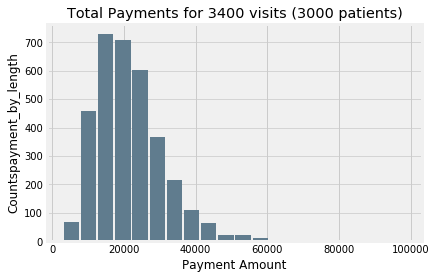

In [532]:
all_merge["total_amount"].plot.hist(grid=True, bins=20, rwidth=0.9,color='#607c8e')
plt.title('Total Payments for 3400 visits (3000 patients)')
plt.ylabel('Countspayment_by_length')
plt.xlabel('Payment Amount')
plt.grid(axis='y', alpha=0.75)

### 2. examine if staying longer drives bill amount up

The two plots below suggests that, staying longer may not suggest paying more in total. For each visit, staying for a period of 6-17 days will usually cost around 20000 in total. Also because the number of data point at two ends are pretty less compared to the middle part, as shown in the histogram below, we cannot say if there is significant difference in total payment between different length of stay.

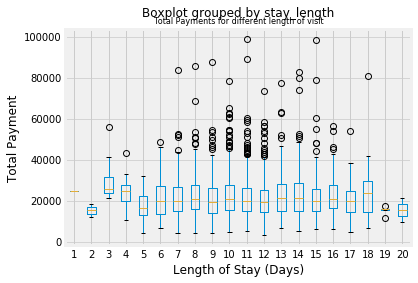

In [533]:
#box plot to see mean and distribution 
df = pd.DataFrame()
df["total_amount"] = all_merge["total_amount"]
df["stay_length"] = all_merge["stay_length"].dt.days

df.boxplot(by='stay_length')
plt.title('Total Payments for different length of visit', fontsize = 8)
plt.ylabel('Total Payment')
plt.xlabel('Length of Stay (Days)')
plt.grid(axis='y', alpha=0.75)
#plt.plot(x, y, 'o', color='black')

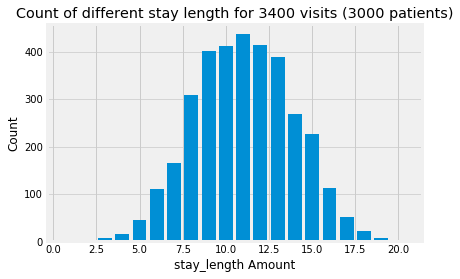

In [534]:
#plot distribution of length of stay
df_group = df.groupby(
   ['stay_length']
).agg(
    frequency = ("total_amount","count")
).reset_index()

plt.bar(df_group["stay_length"],df_group["frequency"])
plt.title('Count of different stay length for 3400 visits (3000 patients)')
plt.ylabel('Count')
plt.xlabel('stay_length Amount')
plt.grid(axis='y', alpha=0.75)

### 3. examine if diffent year of admission drives bill amount up

It seems that the payment for different years are roughly the same, in both amounts and number of visits, only that the payment goes slightly up for 2013 and 2014, and we need a test to see if there is a significant difference.


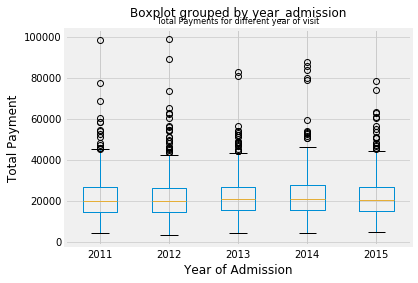

In [535]:
df = pd.DataFrame()
df["total_amount"] = all_merge["total_amount"]
df['year_admission'] = pd.to_datetime(all_merge["date_of_admission"]).dt.year

df.boxplot(by='year_admission')
plt.title('Total Payments for different year of visit', fontsize = 8)
plt.ylabel('Total Payment')
plt.xlabel('Year of Admission')
plt.grid(axis='y', alpha=0.75)
#plt.plot(x, y, 'o', color='black')

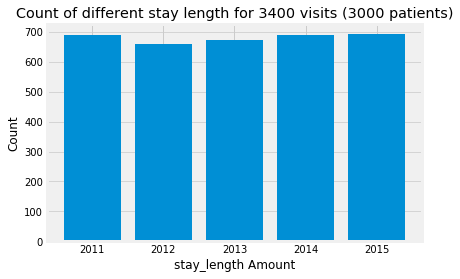

In [536]:
df_group= df.groupby(
   ['year_admission']
).agg(
    frequency = ("total_amount","count")
).reset_index()

plt.bar(df_group["year_admission"],df_group["frequency"])
plt.title('Count of different stay length for 3400 visits (3000 patients)')
plt.ylabel('Count')
plt.xlabel('stay_length Amount')
plt.grid(axis='y', alpha=0.75)

## Model Analysis

### 1.preprocessing dataset before model building

create age based on dob

In [537]:
all_merge["stay_length"] = all_merge["stay_length"].dt.days

all_merge["age"] =pd.to_datetime(date.today()) - pd.to_datetime(all_merge["date_of_birth"])
all_merge["age"]= (all_merge["age"].dt.days)//365
#all_merge.head(3)


create dummy variables for gender, race and resident status

In [538]:
gender_dummy = pd.get_dummies(all_merge["gender"])
race_dummy = pd.get_dummies(all_merge["race"])
resident_dummy = pd.get_dummies(all_merge["resident_status"])
all_merge = pd.concat([all_merge,race_dummy,resident_dummy,gender_dummy],axis =1)
#all_merge.head()


replace na value with null

In [539]:
all_merge.isnull().sum()

all_merge["medical_history_2"].fillna(0, inplace=True)
all_merge["medical_history_5"].fillna(0, inplace=True)


select independent and dependent variables

In [540]:
X = all_merge[['medical_history_1', 'medical_history_2', 'medical_history_3','medical_history_4', 
              'medical_history_5', 'medical_history_6','medical_history_7', 'preop_medication_1', 
              'preop_medication_2','preop_medication_3', 'preop_medication_4', 'preop_medication_5',
              'preop_medication_6', 'symptom_1', 'symptom_2', 'symptom_3',
              'symptom_4', 'symptom_5',"med_history_record","preop_med_record","symptom_record",'lab_result_1', 'lab_result_2',
              'lab_result_3', 'weight', 'height','stay_length', 'Female', "Male",'Chinese', 'Indian', 'Malay',
               'Others', 'Foreigner', 'PR', 'Singaporean', 'age']]
y = all_merge["total_amount"]

check multicolinearity

seems that no VIF >10 suggests no high correlation among independent variables

In [541]:
def calculate_vif_(X, thresh=10.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [542]:
calculate_vif_(X,10)

dropping 'medical_history_1' at index: 0
dropping 'preop_medication_1' at index: 6
dropping 'symptom_1' at index: 11
dropping 'Female' at index: 24
dropping 'Chinese' at index: 25
dropping 'Singaporean' at index: 30
dropping 'height' at index: 22
dropping 'lab_result_2' at index: 19
dropping 'preop_med_record' at index: 16
dropping 'lab_result_1' at index: 17
dropping 'symptom_record' at index: 16
dropping 'weight' at index: 17
dropping 'lab_result_3' at index: 16
dropping 'med_history_record' at index: 15
dropping 'age' at index: 22
dropping 'stay_length' at index: 15
Remaining variables:
Index(['medical_history_2', 'medical_history_3', 'medical_history_4',
       'medical_history_5', 'medical_history_6', 'medical_history_7',
       'preop_medication_2', 'preop_medication_3', 'preop_medication_4',
       'preop_medication_5', 'preop_medication_6', 'symptom_2', 'symptom_3',
       'symptom_4', 'symptom_5', 'Male', 'Indian', 'Malay', 'Others',
       'Foreigner', 'PR'],
      dtype='obj

,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_2,symptom_3,symptom_4,symptom_5,Male,Indian,Malay,Others,Foreigner,PR
0,0.0,0,0,0.0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,1.0,0,0,0.0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0
2,1.0,0,0,0.0,0,1,0,1,1,1,0,1,0,0,1,1,1,0,0,0,0
3,0.0,0,0,0.0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0
4,1.0,0,0,0.0,1,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,1.0,0,0,0.0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
3396,0.0,0,0,0.0,0,0,1,1,1,1,1,1,0,1,0,1,0,0,0,0,0
3397,1.0,0,0,1.0,0,0,1,1,1,1,1,0,1,1,1,1,0,0,0,0,1
3398,0.0,0,0,0.0,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0,0,0


In [543]:
X_vif = X[['medical_history_2', 'medical_history_3', 'medical_history_4',
          'medical_history_5', 'medical_history_6', 'medical_history_7',
          'preop_medication_2', 'preop_medication_3', 'preop_medication_4',
          'preop_medication_5', 'preop_medication_6', 'symptom_2', 'symptom_3',
          'symptom_4', 'symptom_5', 'Male', 'Indian', 'Malay', 'Others',
          'Foreigner', 'PR']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns
vif


,VIF Factor,features
0,1.393786,medical_history_2
1,1.159095,medical_history_3
2,1.060516,medical_history_4
3,1.065141,medical_history_5
4,1.330886,medical_history_6
5,1.329396,medical_history_7
6,2.325320,preop_medication_2
7,4.633946,preop_medication_3
8,2.049566,preop_medication_4
9,4.630957,preop_medication_5


### 2. fit a linear regression to find out what variables are significant to the amount paid

In [544]:
#standardise the dataset
X_scaled = preprocessing.scale(X_vif)

# create linear regression object 
reg = linear_model.LinearRegression() 
  
# train the model using the training sets 
reg.fit(X_scaled, y) 
  
#print model summary
X_scaled_df = pd.DataFrame(preprocessing.scale(X_vif))

X_scaled_df.columns = X_vif.columns

X2 = sm.add_constant(X_scaled_df)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     477.3
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        20:16:28   Log-Likelihood:                -33849.
No. Observations:                3400   AIC:                         6.774e+04
Df Residuals:                    3378   BIC:                         6.788e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.186e+04     87

### Further Findings based on linear model
Based on the result of linear regression, if we adopt a significance level of 5%, it seems that the significant factors are:

1. medical_history (2,5,6,7)
2. preop_medication (2 only), 
3. symptom (2-5), 
4. Gender (Male), 
5. race,
6. residence status 


Also because I standardised the dataset, the coefficients are Standardized coefficients which signify the mean change of the dependent variable given a one standard deviation shift in an independent variable.By identifying the independent variable that has the largest absolute value for its standardized coefficient, I notice that:

1. all presence of medical_history (2,5,6,7), preop_medication(2 only) and symptoms (2-5) will increase the total amount. In particular, Symptom 5 has the largest impact on the amount paid -- the occurance of symptom5 will increase the payment amount by 5121.1355 units.
2. Male patients tend to pay more than female patients by 418.3905 units for each person.
3. regarding races, it seems that Malays will pay more than the rest, whereas Chinese will pay much less
4. regarding the resident status, it seems that foreigners will pay much more than PR and Singaporeans, and Singaporeans will be subsidised the most compared to the rest.



### 3. try clustering method to see which cluster has higher payment 

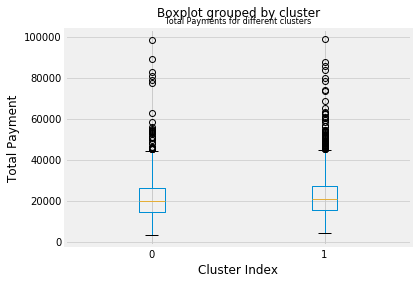

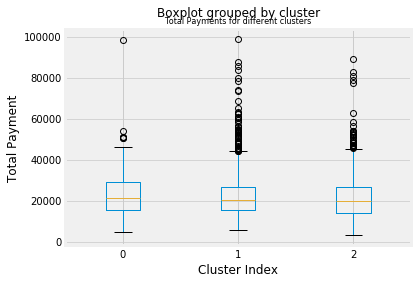

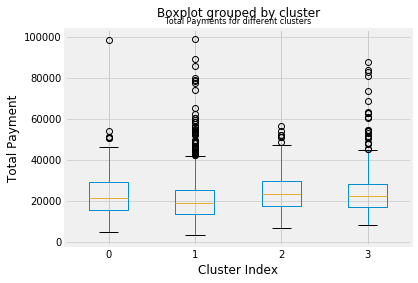

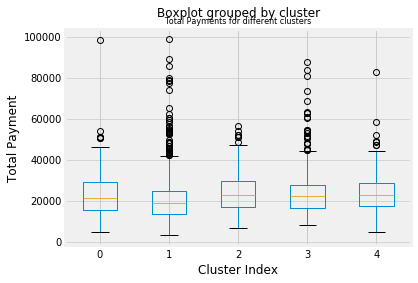

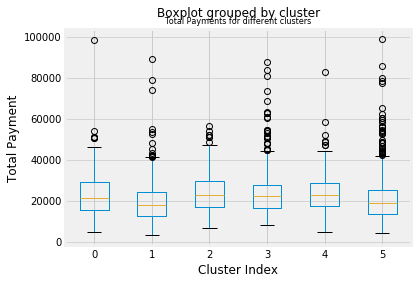

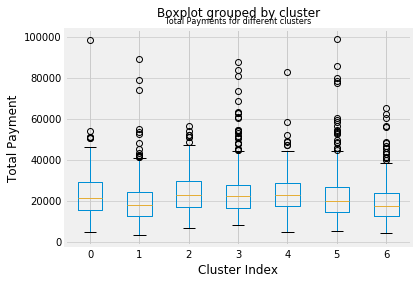

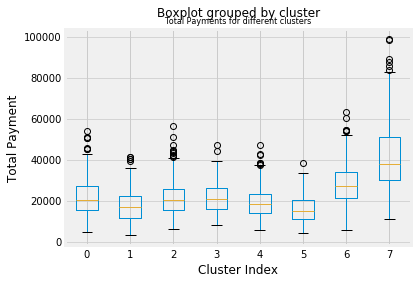

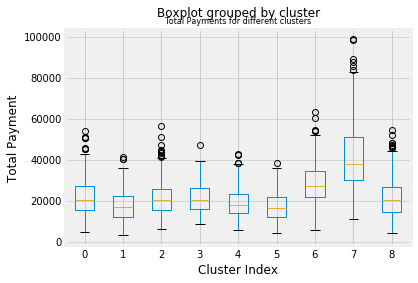

In [545]:
#create a new df with all independent variables and dependent variable
all_merge_data = X_vif
all_merge_data["total_amount"] = y
#can save data to csv for future use
#all_merge_data.to_csv("all_merge_data.csv",encoding='utf-8', index=False)

def run_kmeans(X_scaled_df,k):
    kmeans = KMeans(n_clusters=k,init='k-means++',max_iter=100, n_init=1, verbose=0, random_state=1234)
    km = kmeans.fit(X_scaled_df)

    cluster_map = pd.DataFrame()
    cluster_map['data_index'] = X_scaled_df.index.values
    cluster_map['cluster'] = km.labels_
    #cluster_map[cluster_map.cluster == 0]

    all_merge_data["index"] = all_merge_data.index.values
    cluster_data = pd.merge(all_merge_data,cluster_map, left_on='index', right_on='data_index')

    df = pd.DataFrame()
    df["total_amount"] = cluster_data["total_amount"]
    df['cluster'] = cluster_data["cluster"]

    df.boxplot(by='cluster')
    plt.title('Total Payments for different clusters', fontsize = 8)
    plt.ylabel('Total Payment')
    plt.xlabel('Cluster Index')
    plt.grid(axis='y', alpha=0.75)


for k in range(2,10):
    run_kmeans(X_scaled_df,k)

Based on the plots, select k=8 for further analysis. Because with k<8, we see the difference between each cluster is not very significant, so it is hard to find much insights for the increasement in payment.


In [546]:
#rerun kmeans for k=8

k=8
kmeans = KMeans(n_clusters=k,init='k-means++',max_iter=100, n_init=1, verbose=0, random_state=1234)
km = kmeans.fit(X_scaled_df)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = X_scaled_df.index.values
cluster_map['cluster'] = km.labels_
  

all_merge_data["index"] = all_merge_data.index.values
cluster_data = pd.merge(all_merge_data,cluster_map, left_on='index', right_on='data_index')


plot the distribution of each factor in different clusters to examine if certain factor contribute to higher payment

### Findings based on clustering analysis

we notice that cluster 7 and 6 have much larger payment amount than the rest, and based on the plot we find that, 
cluster 7 are all foreigner patients, and cluster 6 was composed by majority of Malays, which further proved our previous analysis that races and residential status are two of the key drivers of payment amount. 

<BarContainer object of 8 artists>


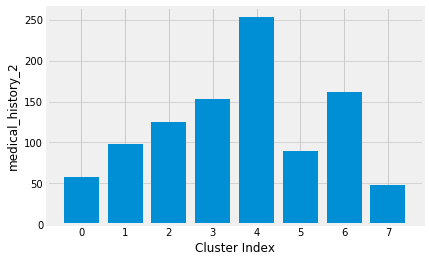

<BarContainer object of 8 artists>


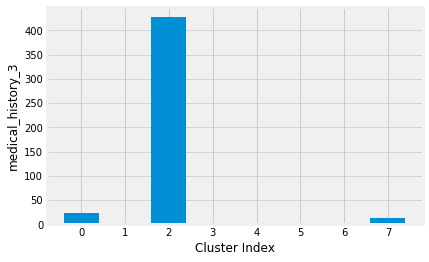

<BarContainer object of 8 artists>


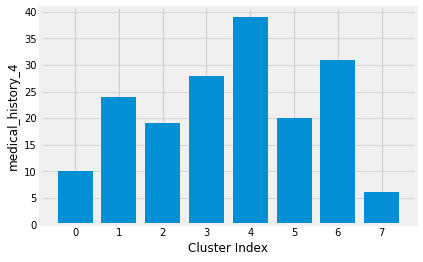

<BarContainer object of 8 artists>


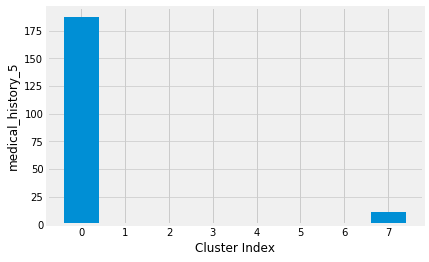

<BarContainer object of 8 artists>


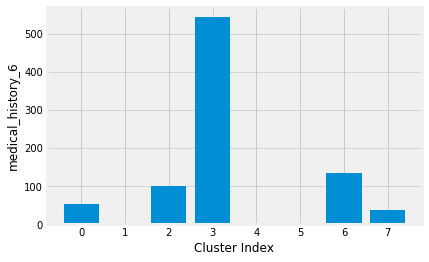

<BarContainer object of 8 artists>


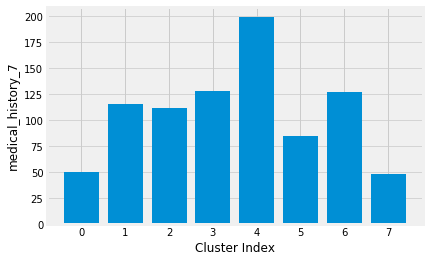

<BarContainer object of 8 artists>


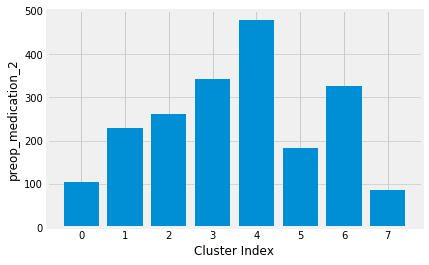

<BarContainer object of 8 artists>


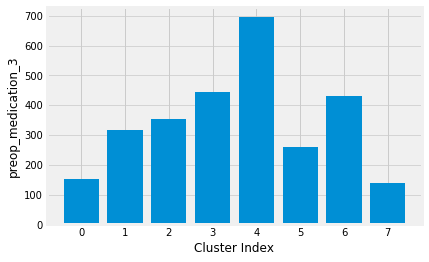

<BarContainer object of 8 artists>


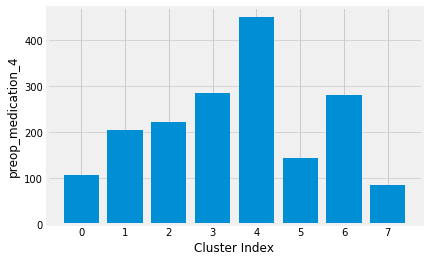

<BarContainer object of 8 artists>


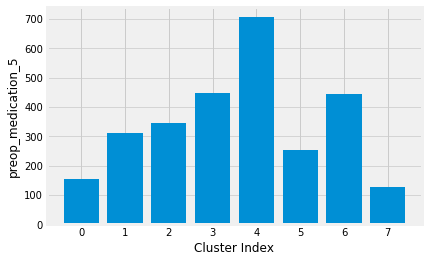

<BarContainer object of 8 artists>


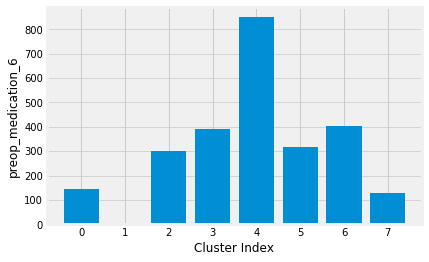

<BarContainer object of 8 artists>


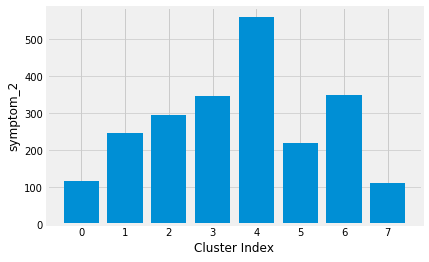

<BarContainer object of 8 artists>


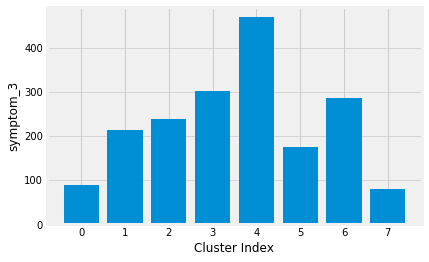

<BarContainer object of 8 artists>


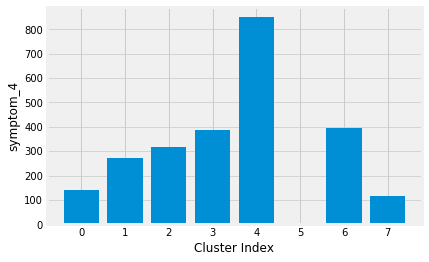

<BarContainer object of 8 artists>


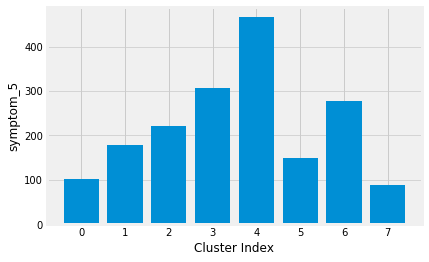

<BarContainer object of 8 artists>


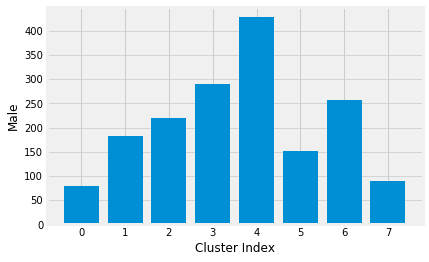

<BarContainer object of 8 artists>


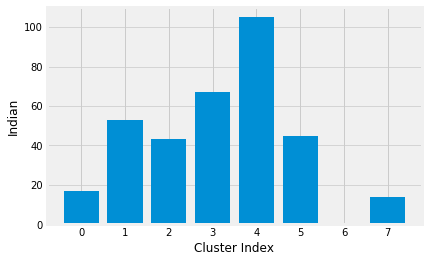

<BarContainer object of 8 artists>


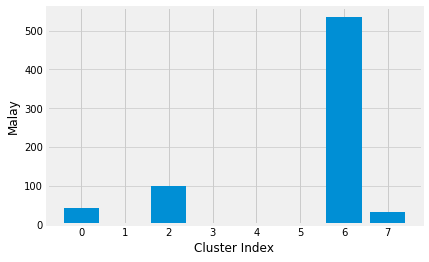

<BarContainer object of 8 artists>


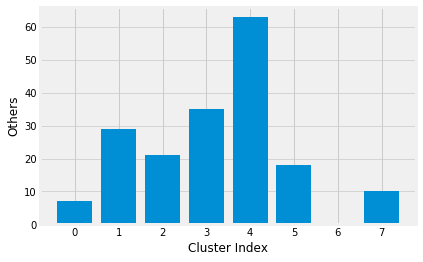

<BarContainer object of 8 artists>


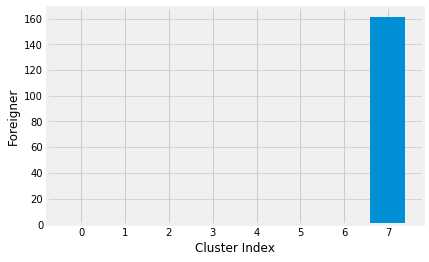

<BarContainer object of 8 artists>


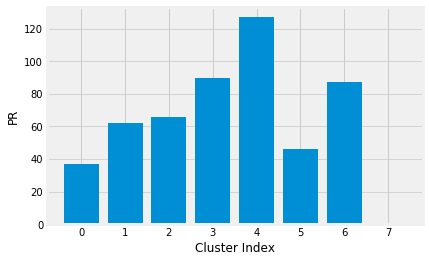

In [547]:
def setdiff_sorted(array1,array2,assume_unique=False):
    ans = np.setdiff1d(array1,array2,assume_unique).tolist()
    if assume_unique:
        return sorted(ans)
    return ans

def boxplot_column(cluster_data,column):

    df = pd.DataFrame()
    df[column] = cluster_data[column]
    df['cluster'] = cluster_data["cluster"]
    
    df.boxplot(by='cluster')
    
    plt.title('Total Payments for different clusters', fontsize = 8)
    plt.ylabel(column)
    plt.xlabel('Cluster Index')
    plt.grid(axis='y', alpha=0.75) 
    
    
def barplot_column(cluster_data,column):

    df = pd.DataFrame()
    df[column] = cluster_data[column]
    df['cluster'] = cluster_data["cluster"]
    df_group= df.groupby(['cluster']).agg(
        frequency = (column,"sum")
    ).reset_index()
    
    barplot = plt.bar(df_group["cluster"],df_group["frequency"])
    plt.ylabel(column)
    plt.xlabel('Cluster Index')
    plt.grid(axis='y', alpha=0.75) 
    print(barplot)

    
#plot the histogram for each factor and for each cluster

for column in cluster_data.columns[:-4]:
    #print(column)
    barplot_column(cluster_data,column)
    plt.show()
